# HACKLIVE 3: NLP HACKATHON 
## Topic Modeling for Research Articles 2.0


In [ ]:
# importing libraries 

import warnings
warnings.filterwarnings("ignore")
#-----------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#-----------------------------------
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
#-----------------------------------
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#------------------------------------
#from sklearn.manifold import TSNE
#Import the Required lib packages for Word-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
#----------------------------------- 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
#-----------------------------------
from collections import Counter
from tqdm import tqdm
#-----------------------------------
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# loading data in Pandas dataframe from csv files

my_path = '/content/gdrive/My Drive/JanataHack/NLP_topic_modeling_hackathon_23102020/'
train_data = pd.read_csv(my_path + 'Train.csv')
test_data = pd.read_csv(my_path + 'Test.csv')

In [ ]:
# train data 
train_data.head()

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# test data

test_data.head()

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,1
1,17934,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
2,16071,we present a stability analysis of the plane c...,0,0,1,0
3,16870,we construct finite time blow-up solutions to ...,0,1,0,0
4,10496,planetary nebulae (pne) constitute an importan...,0,0,1,0


In [ ]:
# train size and test size 

print("Train size:", train_data.shape)
print("Test size:", test_data.shape)

Train size: (14004, 31)
Test size: (6002, 6)


In [ ]:
# train data info 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   id                                            14004 non-null  int64 
 1   ABSTRACT                                      14004 non-null  object
 2   Computer Science                              14004 non-null  int64 
 3   Mathematics                                   14004 non-null  int64 
 4   Physics                                       14004 non-null  int64 
 5   Statistics                                    14004 non-null  int64 
 6   Analysis of PDEs                              14004 non-null  int64 
 7   Applications                                  14004 non-null  int64 
 8   Artificial Intelligence                       14004 non-null  int64 
 9   Astrophysics of Galaxies                      14004 non-null  int64 
 10

In [ ]:
# test data info 
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6002 entries, 0 to 6001
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                6002 non-null   int64 
 1   ABSTRACT          6002 non-null   object
 2   Computer Science  6002 non-null   int64 
 3   Mathematics       6002 non-null   int64 
 4   Physics           6002 non-null   int64 
 5   Statistics        6002 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 281.5+ KB


In [ ]:
# check for null values of any 

print(train_data.isnull().sum())
print("- "* 50)
print(test_data.isnull().sum())

id                                              0
ABSTRACT                                        0
Computer Science                                0
Mathematics                                     0
Physics                                         0
Statistics                                      0
Analysis of PDEs                                0
Applications                                    0
Artificial Intelligence                         0
Astrophysics of Galaxies                        0
Computation and Language                        0
Computer Vision and Pattern Recognition         0
Cosmology and Nongalactic Astrophysics          0
Data Structures and Algorithms                  0
Differential Geometry                           0
Earth and Planetary Astrophysics                0
Fluid Dynamics                                  0
Information Theory                              0
Instrumentation and Methods for Astrophysics    0
Machine Learning                                0


In [ ]:
# how many test points have multiple tags 

count = 0
for i in range(train_data.shape[0]):
    if sum(train_data.iloc[i, 6:]) > 1:
        count += 1

print(count)

4247


Out of total train points, 4247 have more than 1 tags.

In [ ]:
# number of samples with more than one tag
my_list = []
for i in range(train_data.shape[0]):
    my_list.append(sum(train_data.iloc[i, 6:]))

pd.Series(my_list).value_counts()

1    9757
2    3744
3     465
4      38
dtype: int64

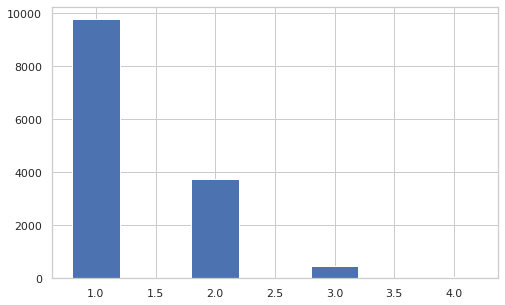

In [ ]:
sns.set(style = 'whitegrid')

my_dict = dict(pd.Series(my_list).value_counts())
plt.figure(figsize = (8, 5))
plt.bar(my_dict.keys(), my_dict.values(), width = 0.4)
plt.show()

In [ ]:
id_col = 'id'

topic_cols = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

target_cols = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control']

In [ ]:
# observe few random abstract texts for deciding the preprocessing steps

for i in range(1000, 14000, 2000):
    print(train_data['ABSTRACT'][i])
    print("- "*50)

graph-based methods are known to be successful inside many machine learning and pattern classification tasks. these methods consider semi-structured data as graphs where nodes correspond to primitives (parts, interest points, segments, etc.) and edges characterize a relationships between these primitives. however, these non-vectorial graph data cannot be straightforwardly plugged into off-the-shelf machine learning algorithms without the preliminary step of -- explicit/implicit -- graph vectorization and embedding. this embedding process should be resilient to intra-class graph variations while being highly discriminant. inside this paper, we propose the novel high-order stochastic graphlet embedding (sge) that maps graphs into vector spaces. our main contribution includes the new stochastic search procedure that efficiently parses the given graph and extracts/samples unlimitedly high-order graphlets. we consider these graphlets, with increasing orders, to model local primitives as wel

In [ ]:
# we need to decontract the english phrases within the questions 
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    #specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    
    # general 
    phrase = re.sub(r"n\'t", " not",   phrase)
    phrase = re.sub(r"\'re", " are",   phrase)
    phrase = re.sub(r"\'s",  " is",    phrase) 
    phrase = re.sub(r"\'d",  " would", phrase)
    phrase = re.sub(r"\'ll", " will",  phrase)
    phrase = re.sub(r"\'t",  " not",   phrase)
    phrase = re.sub(r"\'ve", " have",  phrase)
    phrase = re.sub(r"\'m",  " am",    phrase)
    phrase = re.sub(r"\'em", " them",  phrase)
    return phrase

In [ ]:
'''from wordcloud import WordCloud, STOPWORDS

stopwords = set(list(STOPWORDS)) 
stopwords
'''

In [ ]:
# list of all the stopwords (except 'no', 'nor' and 'not') 
# https://gist.github.com/sebleier/554280

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", 'would', 'could', 'br'] # 'br' added to handle line-breaks 

In [ ]:
# Stemming using Porter Stemmer | reference: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

import nltk
nltk.download('punkt')
def stemming(sentence):
    token_words = word_tokenize(sentence)
    stem_sentence = []
    for word in token_words:  
        stemmer = PorterStemmer()
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# text preprocessing pipeline 

def text_preprocessing(text):
    preprocessed_abstract = []
    for sentence in tqdm(text):
        sent = decontracted(sentence)
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent) 
        sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopwords)
        sent = stemming(sent)
        preprocessed_abstract.append(sent.strip())
    return preprocessed_abstract

In [ ]:
# preprocessing train data abstract text

train_data['preprocessed_abstract'] = text_preprocessing(train_data['ABSTRACT'].values)

train_data[['ABSTRACT', 'preprocessed_abstract']].head()

100%|██████████| 14004/14004 [00:49<00:00, 281.43it/s]


,ABSTRACT,preprocessed_abstract
0,a ever-growing datasets inside observational a...,ever grow dataset insid observ astronomi chall...
1,we propose the framework considering optimal $...,propos framework consid optim match exclud pre...
2,nanostructures with open shell transition meta...,nanostructur open shell transit metal molecula...
3,stars are self-gravitating fluids inside which...,star self gravit fluid insid pressur buoyanc r...
4,deep neural perception and control networks ar...,deep neural percept control network like key c...


In [ ]:
# preprocessing test data abstract text

test_data['preprocessed_abstract'] = text_preprocessing(test_data['ABSTRACT'].values)

test_data[['ABSTRACT', 'preprocessed_abstract']].head()

100%|██████████| 6002/6002 [00:21<00:00, 283.72it/s]


,ABSTRACT,preprocessed_abstract
0,fundamental frequency (f0) approximation from ...,fundament frequenc f0 approxim polyphon music ...
1,"this large-scale study, consisting of 24.5 mil...",larg scale studi consist 24 5 million hand hyg...
2,we present a stability analysis of the plane c...,present stabil analysi plane couett flow stabl...
3,we construct finite time blow-up solutions to ...,construct finit time blow solut 2 dimension ha...
4,planetary nebulae (pne) constitute an importan...,planetari nebula pne constitut import tool stu...


In [ ]:
# combine all the text data to build vocabulary 

combined_vocab = list(train_data['preprocessed_abstract']) + list(test_data['preprocessed_abstract'])

In [ ]:
# splitting train data -> train data + validation data

X = train_data[['Computer Science', 'Mathematics', 'Physics', 'Statistics', 'preprocessed_abstract']]
y = train_data[target_cols]

from sklearn.model_selection import train_test_split

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.25, random_state = 21)
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)

(10503, 5) (10503, 25)
(3501, 5) (3501, 25)


In [ ]:
# TF-IDF Vectorization 

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.5, sublinear_tf = True, 
                             ngram_range = (1, 1))
vectorizer.fit(combined_vocab)

X_train_tfidf = vectorizer.transform(X_train['preprocessed_abstract'])
X_cv_tfidf = vectorizer.transform(X_cv['preprocessed_abstract'])

print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)

(10503, 9136) (10503, 25)
(3501, 9136) (3501, 25)


In [ ]:
# stacking the data for modeling
from scipy.sparse import hstack

X_train_data_tfidf = hstack((X_train[topic_cols], X_train_tfidf))
X_cv_data_tfidf = hstack((X_cv[topic_cols], X_cv_tfidf))

print(X_train_data_tfidf.shape, y_train.shape)
print(X_cv_data_tfidf.shape, y_cv.shape)

(10503, 9140) (10503, 25)
(3501, 9140) (3501, 25)


In [ ]:
# hyperparameter tuning 'C' 
# One vs rest classifier with logistic regression 
%%time

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

C_range = [0.01, 0.1, 1, 10, 100]

for i in C_range:
    clf = OneVsRestClassifier(LogisticRegression(C = i, solver = 'sag', n_jobs = -1))
    clf.fit(X_train_data_tfidf, y_train)
    y_pred_train = clf.predict(X_train_data_tfidf)
    y_pred_cv = clf.predict(X_cv_data_tfidf)
    f1_score_train = f1_score(y_train, y_pred_train, average = 'micro')
    f1_score_cv = f1_score(y_cv, y_pred_cv, average = 'micro')

    print("C:", i, "Train Score:",f1_score_train, "CV Score:", f1_score_cv)
    print("- "*50)

C: 0.01 Train Score: 0.2433689807262401 CV Score: 0.24125495852866932
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
C: 0.1 Train Score: 0.3222874237717179 CV Score: 0.316512186749056
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
C: 1 Train Score: 0.7698558981233244 CV Score: 0.6738360655737705
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
C: 10 Train Score: 0.9719875821240344 CV Score: 0.7467105263157896
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
C: 100 Train Score: 0.9999644469726597 CV Score: 0.7415220596574799
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
CPU times: user 6.43 s, sys: 622 ms, total: 7.05 s
Wall time: 1min 37s


In [ ]:
# hyperparameter tuning 'C' 
# One vs rest classifier with logistic regression 

C_range = [10, 20, 40, 70, 100]

for i in C_range:
    clf = OneVsRestClassifier(LogisticRegression(C = i, solver = 'sag', n_jobs = -1))
    clf.fit(X_train_data_tfidf, y_train)
    y_pred_train = clf.predict(X_train_data_tfidf)
    y_pred_cv = clf.predict(X_cv_data_tfidf)
    f1_score_train = f1_score(y_train, y_pred_train, average = 'micro')
    f1_score_cv = f1_score(y_cv, y_pred_cv, average = 'micro')

    print("C:", i, "Train Score:",f1_score_train, "CV Score:", f1_score_cv)
    print("- "*50)

C: 10 Train Score: 0.9719875821240344 CV Score: 0.7467105263157896
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
C: 20 Train Score: 0.9931206558545713 CV Score: 0.7493917274939172
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
C: 40 Train Score: 0.9986131360904662 CV Score: 0.7473081328751433
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
C: 70 Train Score: 0.999751093411087 CV Score: 0.7431557423605588
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
C: 100 Train Score: 0.9999644469726597 CV Score: 0.7417744497390515
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Thus, C = 20

### Deciding the right threshold

In [ ]:
X_cv_data_tfidf.shape

(3501, 9140)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = OneVsRestClassifier(LogisticRegression(C = 20, solver = 'sag', n_jobs = -1)) 
clf.fit(X_train_data_tfidf, y_train)
y_pred_train_proba = clf.predict_proba(X_train_data_tfidf)
y_pred_cv_proba = clf.predict_proba(X_cv_data_tfidf)

In [ ]:
y_pred_cv_proba

array([[3.79396592e-07, 2.20881182e-05, 1.71117371e-01, ...,
        7.07265546e-05, 4.88317627e-05, 1.63590330e-01],
       [1.45394901e-07, 4.96759791e-06, 7.05507139e-02, ...,
        2.11107619e-05, 1.22927041e-05, 6.81844981e-03],
       [3.60735599e-07, 1.47764047e-05, 1.73421181e-01, ...,
        1.07032350e-05, 1.78404319e-05, 4.65502244e-03],
       ...,
       [1.95939520e-05, 9.95825228e-05, 4.81000587e-06, ...,
        7.04150335e-01, 9.55637925e-01, 1.35204964e-06],
       [9.91113560e-01, 9.76548738e-06, 5.47368033e-07, ...,
        2.07254207e-03, 4.91099614e-03, 4.04460579e-05],
       [5.42213984e-09, 1.43730395e-03, 1.52831734e-01, ...,
        4.49009179e-06, 6.82246727e-06, 1.95454641e-02]])

In [ ]:
def get_best_thresholds(true, pred):
    thresholds = [i/100 for i in range(100)]
    best_thresholds = []
    for idx in range(25):
        f1_scores = [f1_score(true[:, idx], (pred[:, idx] > thresh) * 1) for thresh in thresholds]
        best_thresh = thresholds[np.argmax(f1_scores)]
        best_thresholds.append(best_thresh)
    return best_thresholds

In [ ]:
best_thresholds = get_best_thresholds(y_cv.values, y_pred_cv_proba)
best_thresholds

[0.45, 0.28, 0.19, 0.46, 0.24, 0.24, 0.24, 0.28, 0.22, 0.2, 0.22, 0.24, 0.24, 0.41, 0.32, 0.15, 0.21, 0.33, 0.33, 0.29, 0.16, 0.66, 0.33, 0.36, 0.4]

In [ ]:
y_pred_cv = np.empty_like(y_pred_cv_proba)
for i, thresh in enumerate(best_thresholds):
    y_pred_cv[:, i] = (y_pred_cv_proba[:, i] > thresh) * 1
  
print(f1_score(y_cv, y_pred_cv, average = 'micro'))

0.7765116517811312


Using above found optimal value of regularization parameter (C = 20) and best thresholds 

In [ ]:
X_tr = train_data[['Computer Science', 'Mathematics', 'Physics', 'Statistics', 'preprocessed_abstract']]
y_tr = train_data[target_cols]

X_te = test_data[['Computer Science', 'Mathematics', 'Physics', 'Statistics', 'preprocessed_abstract']]
print(X_tr.shape, y_tr.shape)
print(X_te.shape)

(14004, 5) (14004, 25)
(6002, 5)


In [ ]:
X_tr_tfidf = vectorizer.transform(X_tr['preprocessed_abstract'])
X_te_tfidf = vectorizer.transform(X_te['preprocessed_abstract'])

print(X_tr_tfidf.shape, y_tr.shape)
print(X_te_tfidf.shape)

(14004, 9136) (14004, 25)
(6002, 9136)


In [ ]:
# TF-IDF Vectorization 

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.5, sublinear_tf = True, 
                             ngram_range = (1, 1), max_features = 10000)
vectorizer.fit(combined_vocab)

X_tr_tfidf = vectorizer.transform(X_tr['preprocessed_abstract'])
X_te_tfidf = vectorizer.transform(X_te['preprocessed_abstract'])

print(X_tr_tfidf.shape, y_tr.shape)
print(X_te_tfidf.shape)

(14004, 9136) (14004, 25)
(6002, 9136)


In [ ]:
# stacking the data for modeling
from scipy.sparse import hstack

X_tr_data_tfidf = hstack((X_tr[topic_cols], X_tr_tfidf))
X_te_data_tfidf = hstack((X_te[topic_cols], X_te_tfidf))

print(X_tr_data_tfidf.shape, y_tr.shape)
print(X_te_data_tfidf.shape)

(14004, 9140) (14004, 25)
(6002, 9140)


### Logistic Regression with TFIDF L2 C = 20 (with thresholding)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = OneVsRestClassifier(LogisticRegression(C = 20, n_jobs = -1)) # default penalty is L2
clf.fit(X_tr_data_tfidf, y_tr)
y_pred_tr_proba = clf.predict_proba(X_tr_data_tfidf)
y_pred_te_proba = clf.predict_proba(X_te_data_tfidf)

In [ ]:
y_pred_te_proba

array([[1.05520039e-07, 9.59804726e-04, 1.08296313e-08, ...,
        1.92653374e-05, 2.48607642e-04, 7.71172547e-09],
       [2.63356797e-08, 8.48443851e-01, 1.17337157e-01, ...,
        8.17892637e-06, 3.69808263e-05, 5.52674059e-03],
       [5.38299182e-05, 1.01343264e-05, 1.41326654e-10, ...,
        1.11015106e-03, 2.15385563e-03, 6.10980310e-06],
       ...,
       [5.69224406e-08, 7.05548880e-07, 9.24906477e-01, ...,
        1.56863163e-06, 5.75309697e-06, 2.48092902e-04],
       [1.35092796e-08, 9.53375721e-02, 2.60804759e-09, ...,
        9.86714738e-05, 9.02050594e-05, 2.13402569e-08],
       [1.14110881e-04, 1.40002020e-05, 3.61553677e-09, ...,
        6.48231699e-01, 3.85914853e-02, 3.68965211e-06]])

In [ ]:
y_pred_te = np.empty_like(y_pred_te_proba)
for i, thresh in enumerate(best_thresholds):
    y_pred_te[:, i] = (y_pred_te_proba[:, i] > thresh) * 1

In [ ]:
pd.DataFrame(y_pred_te).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# make submission 

ss = pd.read_csv(my_path + 'SampleSubmission.csv')
ss[target_cols] = y_pred_te
ss.to_csv(my_path + 'combined1000_LR_tfidf_L2_C20_thresh.csv', index = False)

micro-F1 Score upon submission: 0.7685393258 

### Logistic Regression with TFIDF L2 C = 10 (with Classifier Chains and  thresholding)

In [ ]:
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = ClassifierChain(LogisticRegression(C = 10, n_jobs = -1), random_state = 21) # default penalty is L
clf.fit(X_tr_data_tfidf, y_tr)
y_pred_tr_proba = clf.predict_proba(X_tr_data_tfidf)
y_pred_te_proba = clf.predict_proba(X_te_data_tfidf)


In [ ]:
y_pred_te_proba

array([[5.31984152e-07, 5.06627026e-04, 4.10243757e-05, ...,
        1.58994516e-04, 6.11620816e-04, 1.19570269e-07],
       [8.16695539e-08, 7.26189463e-01, 3.09424803e-02, ...,
        9.13965273e-06, 5.99373480e-05, 2.32652375e-01],
       [1.41328160e-04, 2.46281488e-05, 5.55569691e-07, ...,
        1.95032517e-03, 2.04194393e-03, 1.38320284e-05],
       ...,
       [3.12909195e-07, 2.52342291e-06, 9.08481907e-01, ...,
        6.31078729e-05, 3.82337011e-05, 4.25089660e-04],
       [1.22096572e-07, 1.46161640e-01, 7.60009066e-05, ...,
        1.39827582e-04, 1.42394371e-04, 1.62597344e-07],
       [2.93676575e-04, 3.60657695e-05, 4.67210371e-05, ...,
        8.23344618e-01, 8.21029626e-02, 1.21703368e-05]])

In [ ]:
y_pred_te = np.empty_like(y_pred_te_proba)
for i, thresh in enumerate(best_thresholds):
    y_pred_te[:, i] = (y_pred_te_proba[:, i] > thresh) * 1

In [ ]:
pd.DataFrame(y_pred_te).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# make submission
ss = pd.read_csv(my_path + 'SampleSubmission.csv')
ss[target_cols] = y_pred_te
ss.to_csv(my_path + 'chain_LR_tfidf_L2_C10_thresh.csv', index = False)

micro-F1 Score upon submission: 0.749537892791128

Among Classifier Chains and OnevsRestClassifier, OnevsRestClassifier gave better peformance on the test set. 
